In [19]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.models import load_model
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
import matplotlib.pyplot as plt

In [20]:
# Paths to your training and validation CSV files and image folders
train_csv = '/kaggle/input/gi-track/Training.csv'
train_image_folder = '/kaggle/input/gi-track/All_Images/Training'

val_csv = '/kaggle/input/gi-track/Validation.csv'
val_image_folder = '/kaggle/input/gi-track/All_Images/Validation'

test_csv = '/kaggle/input/gi-track/Testing.csv'
test_image_folder = '/kaggle/input/gi-track/All_Images/Testing'

# Load training and validation data from CSV files
train_data = pd.read_csv(train_csv)
train_data['class'] = train_data['class'].astype(str)

val_data = pd.read_csv(val_csv)
val_data['class'] = val_data['class'].astype(str)

# Load test data CSV
test_data = pd.read_csv(test_csv)
test_data['class'] = test_data['class'].astype(str)

# Create an ImageDataGenerator for training data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  # Ensure class_mode is 'binary' and 'y_col' values are strings
)

# Flow from dataframe for validation
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=val_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',  # Ensure class_mode is 'binary' and 'y_col' values are strings
    shuffle=False
)

# Flow from dataframe for test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',  # Ensure class_mode is 'binary' and 'y_col' values are strings
    shuffle=False
)

Found 2412 validated image filenames belonging to 2 classes.
Found 244 validated image filenames belonging to 2 classes.
Found 521 validated image filenames belonging to 2 classes.


In [42]:
# Load the ResNet50 model pre-trained on ImageNet, without the top layer
weights_path = '/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = ResNet50(weights=weights_path, include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define the model using the functional API
inputs = Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Set up early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │   134,218,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,807,489 (601.99 MB)

 Trainable params: 134,219,777 (512.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
 2/76 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.4688 - loss: 5.4607  

W0000 00:00:1719902708.099898     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.4987 - loss: 2.7344

W0000 00:00:1719902724.362611     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 270ms/step - accuracy: 0.4991 - loss: 2.7161 - val_accuracy: 0.5123 - val_loss: 0.6840
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.5675 - loss: 0.6803 - val_accuracy: 0.6844 - val_loss: 0.6471
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.6015 - loss: 0.6598 - val_accuracy: 0.5697 - val_loss: 0.6392
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.6142 - loss: 0.6385 - val_accuracy: 0.7295 - val_loss: 0.6082
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.6418 - loss: 0.6286 - val_accuracy: 0.6803 - val_loss: 0.6065
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.6552 - loss: 0.6104 - val_accuracy: 0.7336 - val_loss: 0.5927
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.6657 - loss: 0.6006 - val_accuracy: 0.7295 - val_loss: 0.5868
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.6801 - loss: 0.5908 - val_accuracy: 0.741

In [43]:
# Save the trained model
model.save('/kaggle/working/Resnet50_Transfer_Mix.h5')

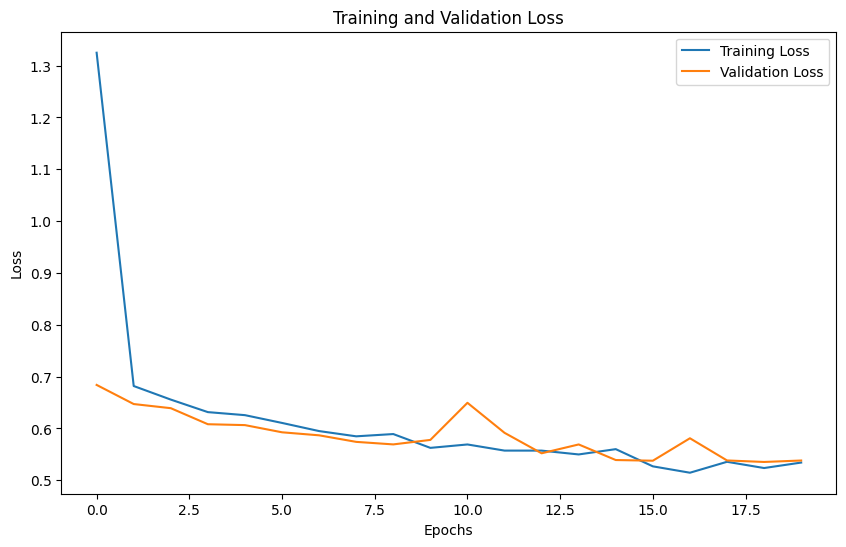

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
# Evaluate the model
val_generator.reset()
predictions = model.predict(val_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = val_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 605ms/step


Confusion Matrix
[[85 24]
 [38 97]]
Classification Report
              precision    recall  f1-score   support

non-bleeding       0.69      0.78      0.73       109
    bleeding       0.80      0.72      0.76       135

    accuracy                           0.75       244
   macro avg       0.75      0.75      0.75       244
weighted avg       0.75      0.75      0.75       244


Class 0 - Non-Bleeding:
Sensitivity: 0.7798
Specificity: 0.7185
True Positive Rate: 0.7798
False Positive Rate: 0.2815

Class 1 - Bleeding:
Sensitivity: 0.7185
Specificity: 0.7798
True Positive Rate: 0.7185
False Positive Rate: 0.2202

ROC Curve Values:
FPR: [0.         0.         0.         0.00917431 0.00917431 0.01834862
 0.01834862 0.02752294 0.02752294 0.03669725 0.03669725 0.04587156
 0.04587156 0.05504587 0.05504587 0.06422018 0.06422018 0.0733945
 0.0733945  0.08256881 0.08256881 0.09174312 0.09174312 0.10091743
 0.10091743 0.11009174 0.11009174 0.11926606 0.11926606 0.12844037
 0.12844037 0.1376146

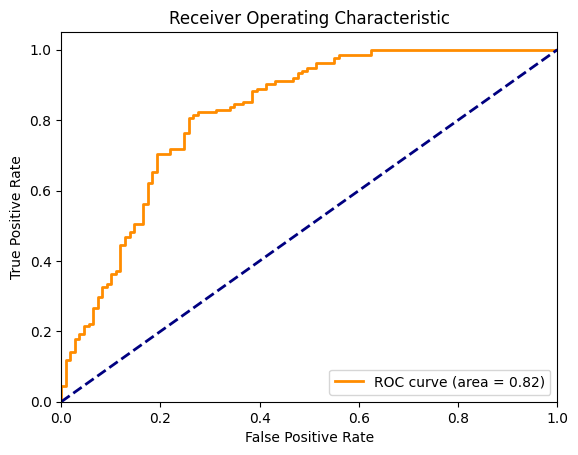

In [46]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(cm)

# Classification report
cr = classification_report(y_true, y_pred, target_names=['non-bleeding', 'bleeding'])
print('Classification Report')
print(cr)

# Sensitivity, Specificity, TPR, FPR for each class
tn, fp, fn, tp = cm.ravel()

# Class 0: Non-Bleeding
sensitivity_0 = tn / (tn + fp)
specificity_0 = tp / (tp + fn)
tpr_0 = sensitivity_0
fpr_0 = fn / (fn + tp)

# Class 1: Bleeding
sensitivity_1 = tp / (tp + fn)
specificity_1 = tn / (tn + fp)
tpr_1 = sensitivity_1
fpr_1 = fp / (fp + tn)

print(f"\nClass 0 - Non-Bleeding:")
print(f"Sensitivity: {sensitivity_0:.4f}")
print(f"Specificity: {specificity_0:.4f}")
print(f"True Positive Rate: {tpr_0:.4f}")
print(f"False Positive Rate: {fpr_0:.4f}")

print(f"\nClass 1 - Bleeding:")
print(f"Sensitivity: {sensitivity_1:.4f}")
print(f"Specificity: {specificity_1:.4f}")
print(f"True Positive Rate: {tpr_1:.4f}")
print(f"False Positive Rate: {fpr_1:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

# Store the ROC curve values for further use or plotting
roc_curve_values = {
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds,
    'roc_auc': roc_auc
}

print(f"\nROC Curve Values:")
print(f"FPR: {roc_curve_values['fpr']}")
print(f"TPR: {roc_curve_values['tpr']}")
print(f"Thresholds: {roc_curve_values['thresholds']}")
print(f"ROC AUC: {roc_curve_values['roc_auc']:.2f}")

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [47]:
# Load the previously saved model
model = tf.keras.models.load_model('/kaggle/working/Resnet50_Transfer_Mix.h5')

# Evaluate the model on test data
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = test_generator.classes

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step


Confusion Matrix
[[263  57]
 [ 54 147]]
Classification Report
              precision    recall  f1-score   support

non-bleeding       0.83      0.82      0.83       320
    bleeding       0.72      0.73      0.73       201

    accuracy                           0.79       521
   macro avg       0.78      0.78      0.78       521
weighted avg       0.79      0.79      0.79       521


Class 0 - Non-Bleeding:
Sensitivity: 0.8219
Specificity: 0.7313
True Positive Rate: 0.8219
False Positive Rate: 0.2687

Class 1 - Bleeding:
Sensitivity: 0.7313
Specificity: 0.8219
True Positive Rate: 0.7313
False Positive Rate: 0.1781

ROC Curve Values:
FPR: [0.       0.003125 0.003125 0.003125 0.003125 0.00625  0.00625  0.009375
 0.009375 0.015625 0.015625 0.01875  0.01875  0.01875  0.028125 0.028125
 0.034375 0.034375 0.034375 0.0375   0.0375   0.040625 0.040625 0.04375
 0.04375  0.05     0.05     0.05625  0.05625  0.0625   0.0625   0.065625
 0.065625 0.06875  0.06875  0.071875 0.071875 0.078125 0.078

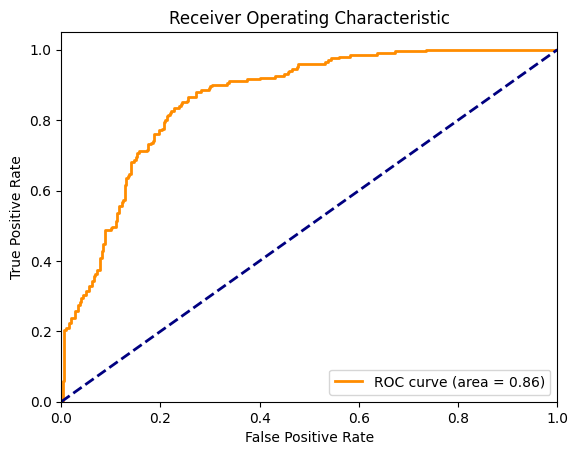

In [48]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(cm)

# Classification report
cr = classification_report(y_true, y_pred, target_names=['non-bleeding', 'bleeding'])
print('Classification Report')
print(cr)

# Calculate Sensitivity, Specificity, TPR, FPR for each class
tn, fp, fn, tp = cm.ravel()

# Class 0: Non-Bleeding
sensitivity_0 = tn / (tn + fp)
specificity_0 = tp / (tp + fn)
tpr_0 = sensitivity_0
fpr_0 = fn / (fn + tp)

# Class 1: Bleeding
sensitivity_1 = tp / (tp + fn)
specificity_1 = tn / (tn + fp)
tpr_1 = sensitivity_1
fpr_1 = fp / (fp + tn)

print(f"\nClass 0 - Non-Bleeding:")
print(f"Sensitivity: {sensitivity_0:.4f}")
print(f"Specificity: {specificity_0:.4f}")
print(f"True Positive Rate: {tpr_0:.4f}")
print(f"False Positive Rate: {fpr_0:.4f}")

print(f"\nClass 1 - Bleeding:")
print(f"Sensitivity: {sensitivity_1:.4f}")
print(f"Specificity: {specificity_1:.4f}")
print(f"True Positive Rate: {tpr_1:.4f}")
print(f"False Positive Rate: {fpr_1:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

# Store the ROC curve values for further use or plotting
roc_curve_values = {
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds,
    'roc_auc': roc_auc
}

print(f"\nROC Curve Values:")
print(f"FPR: {roc_curve_values['fpr']}")
print(f"TPR: {roc_curve_values['tpr']}")
print(f"Thresholds: {roc_curve_values['thresholds']}")
print(f"ROC AUC: {roc_curve_values['roc_auc']:.2f}")

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()